# Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import pathlib

# Check GPU

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.list_logical_devices('GPU')
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

# Datasets

In [31]:
batch_size = 32
img_size = (224, 224)

ROOT_PATH = './drive/MyDrive/Colab Drive/hotdogclassifier'
train_dir = os.path.join(ROOT_PATH, 'train')
test_dir = os.path.join(ROOT_PATH, 'test')

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             validation_split=0.2,
                                             subset="training",
                                             seed=8,
                                             batch_size=batch_size,
                                             image_size=img_size)

validation_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             validation_split=0.2,
                                             subset="validation",
                                             seed=8,
                                             batch_size=batch_size,
                                             image_size=img_size)

test_dataset = image_dataset_from_directory(test_dir,
                                             batch_size=batch_size,
                                             image_size=img_size)

class_names = train_dataset.class_names
print(class_names)


Found 3000 files belonging to 2 classes.
Using 2400 files for training.
Found 3000 files belonging to 2 classes.
Using 600 files for validation.
Found 644 files belonging to 2 classes.
['hotdog', 'nothotdog']


In [5]:
print(train_dataset)

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


# Visualize Data

tf.Tensor(
[[[[1.05523544e+02 7.86216431e+01 4.90204010e+01]
   [1.09190445e+02 8.26308670e+01 5.21276169e+01]
   [1.10979843e+02 8.50151062e+01 5.16439056e+01]
   ...
   [8.00000000e+00 4.00000000e+00 1.00000000e+00]
   [8.00000000e+00 4.00000000e+00 1.00000000e+00]
   [8.91601562e+00 5.83203125e+00 1.00000000e+00]]

  [[7.85175781e+01 5.39664726e+01 3.07301445e+01]
   [8.82665863e+01 6.52109222e+01 3.94785004e+01]
   [1.01014038e+02 7.69053345e+01 5.06611900e+01]
   ...
   [8.10580063e+00 4.10580063e+00 1.10580063e+00]
   [8.00000000e+00 4.00000000e+00 1.00000000e+00]
   [8.91601562e+00 5.83203125e+00 1.00000000e+00]]

  [[4.35388412e+01 2.47846031e+01 8.47829437e+00]
   [5.10009193e+01 3.34023056e+01 1.56480675e+01]
   [5.96780624e+01 4.15084343e+01 2.32810249e+01]
   ...
   [8.24358749e+00 4.24358749e+00 1.24358749e+00]
   [8.00000000e+00 4.00000000e+00 1.00000000e+00]
   [8.53136063e+00 5.44737625e+00 6.15345001e-01]]

  ...

  [[1.07345963e+01 1.27345963e+01 9.73459625e+00]
   [1

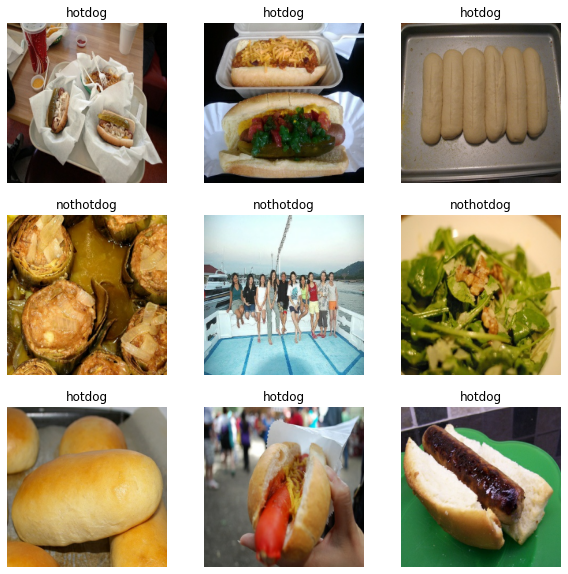

In [7]:
plt.figure(figsize=(10, 10))
for ind, (images, labels) in enumerate(train_dataset):
    if ind > 0: break
    print(images, labels)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Data Augmentation Function

In [11]:
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.1)
    ]
)

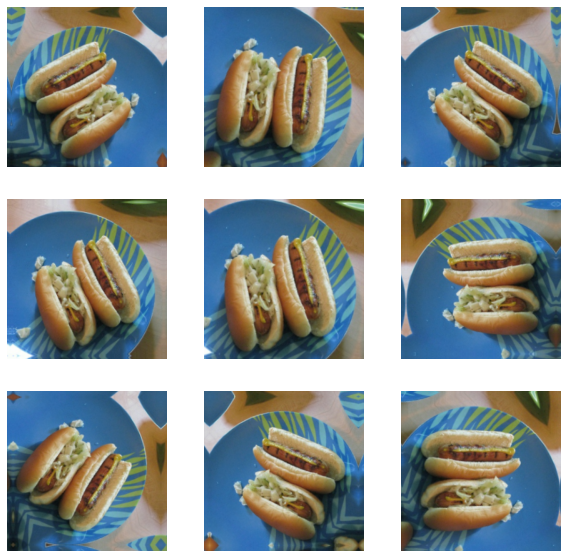

In [13]:
for ind, (image, _) in enumerate(train_dataset):
    if ind > 0: break
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

# Learning Curve Plotting Function

In [14]:
def plotLearningCurve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

# Define Model

In [42]:
base_model_mobilenet_v3 = tf.keras.applications.MobileNetV3Small(weights = 'imagenet', include_top = False, input_shape = (224,224,3))
base_model_mobilenet_v3.trainable = False
inputs = tf.keras.Input(shape=(224, 224, 3), name='image')
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v3.preprocess_input(x)
x = base_model_mobilenet_v3(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(1000, activation='relu')(x)
x = layers.Dropout(.3)(x)
outputs = layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs, name='mobilenet_v3')

model.summary()


Model: "mobilenet_v3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, None, None, 3)     0         
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d_9   (None, 576)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_9 (Flatten)         (None, 576)               0         
                                                                 
 dense_18 (Dense)            (None, 1000)             

# Compile and Train Model

Epoch 1/20
75/75 [==============================] - 12s 114ms/step - loss: 0.2718 - accuracy: 0.8846 - val_loss: 0.2244 - val_accuracy: 0.9017
Epoch 2/20
75/75 [==============================] - 9s 107ms/step - loss: 0.2333 - accuracy: 0.9042 - val_loss: 0.2126 - val_accuracy: 0.9067
Epoch 3/20
75/75 [==============================] - 10s 121ms/step - loss: 0.2211 - accuracy: 0.9038 - val_loss: 0.2435 - val_accuracy: 0.8833
Epoch 4/20
75/75 [==============================] - 9s 110ms/step - loss: 0.2220 - accuracy: 0.9033 - val_loss: 0.2056 - val_accuracy: 0.9117
Epoch 5/20
75/75 [==============================] - 8s 100ms/step - loss: 0.1897 - accuracy: 0.9121 - val_loss: 0.2025 - val_accuracy: 0.9050
Epoch 6/20
75/75 [==============================] - 8s 102ms/step - loss: 0.1969 - accuracy: 0.9192 - val_loss: 0.1961 - val_accuracy: 0.9167
Epoch 7/20
75/75 [==============================] - 8s 100ms/step - loss: 0.1779 - accuracy: 0.9217 - val_loss: 0.1891 - val_accuracy: 0.9200
Epoc

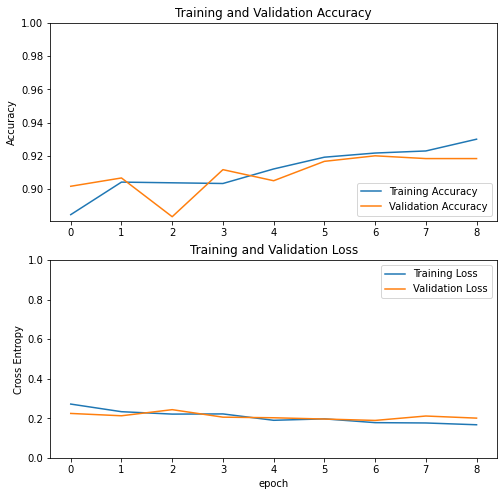

INFO:tensorflow:Assets written to: model_mobilenet_v3/assets


INFO:tensorflow:Assets written to: model_mobilenet_v3/assets


In [44]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
                              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                              metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(train_dataset,
                                    epochs=20,
                                    validation_data=validation_dataset,
                                    callbacks=[callback])

plotLearningCurve(history)

model.save('model_mobilenet_v3')

# Test Dataset

21/21 [==============================] - 2s 60ms/step - loss: 0.1546 - accuracy: 0.9255


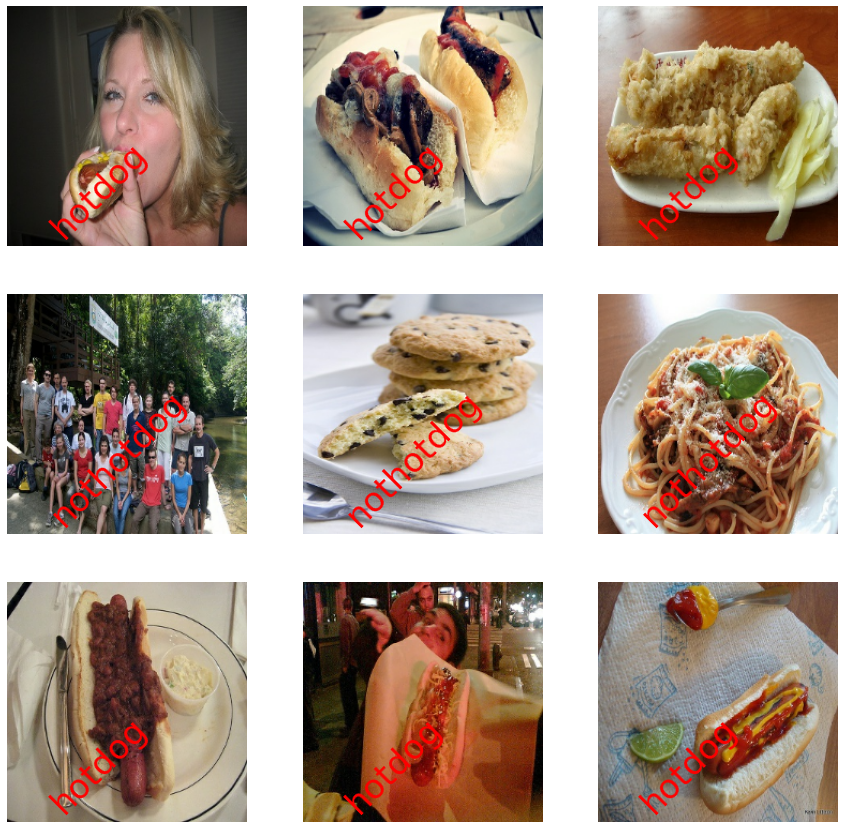

In [45]:
model.evaluate(test_dataset)

image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions <= 0.5, 0, 1)

plt.figure(figsize=(15, 15))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    label = class_names[predictions[i]]
    if label=='Hot Dog':
        plt.text(50, 200, label, rotation=45, color='lightgreen', fontsize=34, fontweight='bold')
    else:
        plt.text(35, 215, label, rotation=45, color='red', fontsize=34, fontweight='normal')
    plt.axis("off")

# Convert to TFJS

In [40]:
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [46]:
import tensorflowjs as tfjs

tfjs.converters.convert_tf_saved_model("model_mobilenet_v3", "tfjs_model4")

Writing weight file tfjs_model4/model.json...


In [51]:
!tar -czf model.tar.gz ./tfjs_model4